In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Data aquisition&preparation

In [21]:
# Oxford-IIIT pet dataset: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet
dataset_name = "oxford_iiit_pet" # dataset name
split = [
    "train[:60%]+test[:60%]",
    "train[60%:80%]+test[60%:80%]",
    "train[80%:]+test[80%:]"
] # train-validation-test split

In [22]:
# Oxford Flowers 102 dataset: https://www.tensorflow.org/datasets/catalog/oxford_flowers102
dataset_name = "oxford_flowers102" # dataset name
split = [
    "train[:60%]+validation[:60%]+test[:60%]",
    "train[60%:80%]+validation[60%:80%]+test[60%:80%]",
    "train[80%:]+validation[80%:]+test[80%:]"
] # train-validation-test split

In [58]:
# Hyperparameters
img_size = 64 # resized image size
batch_size = 64 # batch size
timesteps = 500 # number of timesteps (noise levels)

latent_dim = 64 # latent dimension
learning_rate = 1e-3 # learning rate
num_epochs = 1 # number of epochs (TODO change to a larger number)

In [24]:
def preprocess_image(data): # preprocess an image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width) # find the smallest dimension
    img = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    ) # crop the image to a square
    img = tf.cast(img, dtype=tf.float32) # cast the image to float32
    img = tf.image.resize(img, size=(img_size, img_size), antialias=True) # resize the image to img_size x img_size
    return tf.clip_by_value(img * 2.0 / 255.0, -1.0, 1.0) # normalize the image to [-1, 1]

def reverse_transform(img):
    return tf.clip_by_value((img + 1.0) / 2.0 * 255.0, 0.0, 255.0).numpy().astype(np.uint8) # reverse the normalization

In [25]:
def preprocess_dataset(dataset): # preprocess a dataset
    return (dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # preprocess images of the dataset
            .batch(batch_size, drop_remainder=True) # organize the dataset into batches
            .shuffle(2 * batch_size) # shuffle the dataset
            .prefetch(buffer_size=tf.data.AUTOTUNE)) # prefetch data for better performance

def load_data(dataset_name): # load dataset from tensorflow datasets with the given name
    train_ds, val_ds, test_ds = tfds.load(dataset_name, split=split, shuffle_files=True) # load the dataset
    train_ds = preprocess_dataset(train_ds) # preprocess the training dataset
    val_ds = preprocess_dataset(val_ds) # preprocess the validation dataset
    test_ds = preprocess_dataset(test_ds) # preprocess the test dataset
    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = load_data(dataset_name)

In [27]:
demo_img = next(iter(train_ds.unbatch().take(1)))

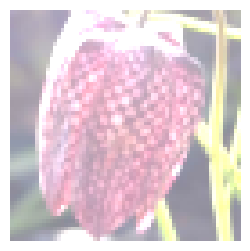

In [28]:
def show(img):
    plt.figure(figsize=(3, 3))
    plt.imshow(reverse_transform(img))
    plt.axis("off")
    plt.show()
    
def plot(imgs):
    _, axs = plt.subplots(figsize=(len(imgs)*2,2), ncols=len(imgs), nrows=1)
    for idx, img in enumerate(imgs):
        axs[idx].imshow(reverse_transform(img))
        axs[idx].axis("off")
    plt.tight_layout()

show(demo_img)

## Forward Diffusion Process 

In [29]:
class Diffusion:
    def __init__(self, timesteps=1000, min_beta=0.0001, max_beta = 0.02):
        self.timesteps = timesteps # number of timesteps (noise levels)
        self.min_beta = min_beta # first beta
        self.max_beta = max_beta # last beta
        
        self.betas = tf.linspace(min_beta, max_beta, timesteps) # setting schedule for beta (linear schedule)
        self.alphas = 1 - self.betas # alpha_t = 1 - beta_t
        self.alphas_cum_prod = tf.math.cumprod(self.alphas) # cumulative product of alphas
        self.alphas_cum_prod_prev = tf.concat([[1.0], self.alphas_cum_prod[:-1]], axis=0) # cumulative product of alphas shifted
        self.recip_sqrt_alphas = tf.math.square(1.0 / self.alphas) # reciprocals of squares of alphas
        self.sqrt_alphas_prod = tf.math.square(self.alphas_cum_prod) # squares of cumulative product of alphas
        self.sqrt_one_minus_alphas_prod = tf.math.square(1.0 - self.alphas_cum_prod) # squares of 1 - cumulative product of alphas
        
        # posterior variance (Equation 6, 7)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cum_prod_prev) / (1.0 - self.alphas_cum_prod)
        
    def extract(self, series, t, x_shape):
        out = tf.gather(series, t)
        return tf.reshape(out, [x_shape[0], 1, 1, 1])
    
    def q_sample(self, x_start, t, noise=None):
        x_start_shape = tf.shape(x_start)
        if noise is None:
            noise = tf.random.normal(x_start_shape, dtype=x_start.dtype)
        
        sqrt_alphas_prod_t = self.extract(self.sqrt_alphas_prod, t, x_start_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_start_shape)
        return sqrt_alphas_prod_t * x_start + sqrt_one_minus_alphas_prod_t * noise # Equation 12
    
    def p_sample_step(self, model, x, t, t_index):
        x_shape = tf.shape(x)
        beta_t = self.extract(self.betas, t, x_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_shape)
        recip_sqrt_alphas_t = self.extract(self.recip_sqrt_alphas, t, x_shape)
        noise_pred = model([x, t])
        model_mean = recip_sqrt_alphas_t * (x - noise_pred * beta_t / sqrt_one_minus_alphas_prod_t) # Equation 11
        
        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = self.extract(self.posterior_variance, t, x_shape)
            noise = tf.random.normal(x_shape, dtype=x.dtype) # sample noise from N(0, I)
            return model_mean + tf.math.square(posterior_variance_t) * noise # Algorith 2, Line 4
        
    def p_sample_full(self, model, shape):
        img = tf.random.normal(shape, dtype=tf.float32) # pure noise initially
        imgs = [img]
        for t in reversed(range(self.timesteps)):
            t_batch = tf.fill((shape[0],), t)
            img = self.p_sample_step(model, img, t_batch, t)
            imgs.append(img)
        return imgs
    
    def generate_image(self, model, image_size):
        return self.p_sample_full(model, (1, image_size, image_size, 3))

In [30]:
forward_diffusion = Diffusion(timesteps)

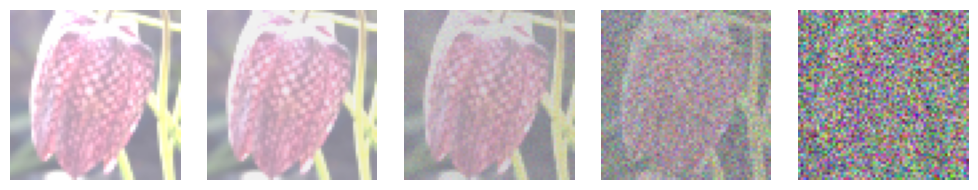

In [31]:
noisy_images = [tf.squeeze(forward_diffusion.q_sample(tf.expand_dims(demo_img, 0), tf.constant([t]))) for t in [0, 50, 100, 150, 200]]
plot(noisy_images)

## Neural network

A basic autoencoder for milestone 2

In [59]:
def build_network(input_shape=(img_size, img_size, 3), latent_dim=64):
    image_input = tf.keras.layers.Input(shape=input_shape)
    time_input = tf.keras.layers.Input(shape=(1,))
    x = tf.keras.layers.Flatten()(image_input)
    combined = tf.keras.layers.Concatenate()([x, time_input])
    
    x = tf.keras.layers.Dense(latent_dim, activation="relu")(combined) # encoder
    x = tf.keras.layers.Dense(np.prod(input_shape), activation="linear")(x) # decoder
    x = tf.keras.layers.Reshape(input_shape)(x)
    
    return tf.keras.Model(inputs=[image_input, time_input], outputs=x, name="basic_autoencoder")

In [60]:
class DiffusionModel(tf.keras.Model):
    def __init__(self, diffusion, net, loss):
        super(DiffusionModel, self).__init__()
        self.diffusion = diffusion
        self.network = net
        self.loss = loss
        
    def train_step(self, Xs):
        t = tf.random.uniform((tf.shape(Xs)[0],), minval=0, maxval=timesteps, dtype=tf.int32)
        with tf.GradientTape() as tape:
            noise = tf.random.normal(tf.shape(Xs), dtype=Xs.dtype)
            Xs_noisy = self.diffusion.q_sample(Xs, t, noise)
            noise_pred = self.network([Xs_noisy, t])
            loss = self.loss(noise, noise_pred)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}


In [61]:
network = build_network(input_shape=(img_size, img_size, 3), latent_dim=latent_dim)
model = DiffusionModel(diffusion=forward_diffusion, net=network, loss=tf.keras.losses.MeanSquaredError())
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [62]:
model.fit(train_ds, epochs=num_epochs, batch_size=batch_size, validation_data=val_ds)

TypeError: in user code:

    File "C:\Users\Csanad\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Csanad\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Csanad\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Csanad\AppData\Local\Temp\ipykernel_17456\1743495165.py", line 14, in train_step
        loss = self.loss(noise, noise_pred)

    TypeError: '_DictWrapper' object is not callable


# Evaluation

TODO: evaluate the model on the test set

## Generate random images

In [56]:
def generate_images(model, N=5):
    for i in range(N):
        imgs = forward_diffusion.generate_image(model, img_size)
        plot(list(reversed(imgs[::(len(imgs) // 5)])))

In [ ]:
generate_images(model)